Learns non-chaotic lorenz with $\rho(t)$ transitioning from 14 to 15.  

In [ ]:
# Import the necessary packages:
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider


#import Networkx as net
#import Plot3D as plot3d

#Neural ODE library
import Neural_ODEs_v1 as nodes
import DynamicalSystems as ds


#set random seed to 107
torch.manual_seed(107)
np.random.seed(107)

# Generating Data

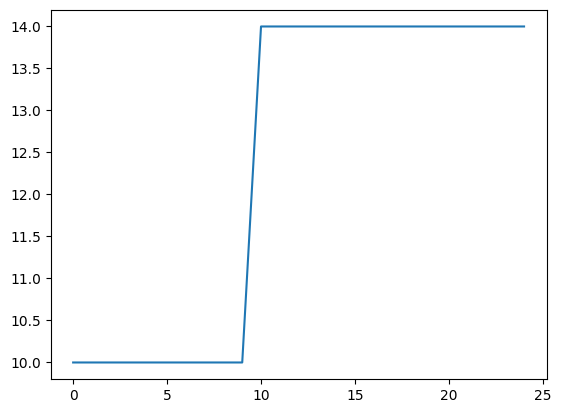

In [ ]:
#r_vals = np.arange(14, 15, 1, dtype=np.float32)
r_vals = [10.0, 14.0]
def rho(t, r_vals = r_vals, step = 10):
    if t < step:
        return r_vals[0]
    elif t >= step:
        return r_vals[1]

plt.plot([rho(t) for t in range(0, 25)])

In [ ]:
lorenz = ds.Lorenz(rho = rho)

#Generating data from Lorenz System with fixed parameters
dt = 0.05
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]
time_spans = [(0, 15)]
list = []

for t_span in time_spans:
    out = lorenz.solve(x0 = initial_conditions, t_span = t_span, dt = dt)
    list.append(np.expand_dims(out, axis=0))

data_full = np.concatenate(list, axis=0)
data_full.shape

(1, 300, 2, 3)

### Normalizing Data

In [ ]:
norm = nodes.normalize_data(data_full.reshape(-1, 3))
data_norm = norm.normalize(data_full)

## Plotting 

In [5]:
data_norm.shape

(1, 300, 2, 3)

In [6]:
def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

    

In [7]:
data_norm[0, :, 0, 0].shape

(300,)

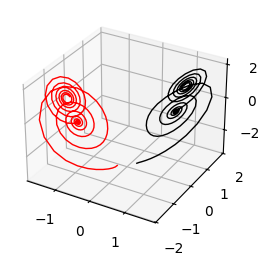

In [9]:

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
#ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
ax1.plot(xs=data_norm[0, :, 0, 0], ys=data_norm[0, :, 0, 1], zs=data_norm[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=data_norm[0, :, 1, 0], ys=data_norm[0, :, 1, 1], zs=data_norm[0, :, 1, 2], color = 'red', linewidth = 1)   



# Training Neural ODE

In [12]:
model = nodes.Piecewise_Auto_NODE(spatial_dim=3, depth=2, width = 30, time_range=[0, 15], num_breakpoints=1, activation_func=nn.Tanh())

In [13]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#Putting data into tensor 
#t_eval_tensor =  torch.tensor(np.arange(tstart, tfinal, dt))
training_data_tensor = torch.tensor(data_norm)

In [14]:
np.array([np.arange(time_spans[i][0], time_spans[i][1], dt) for i in range(len(time_spans))])

array([[ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
         1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,
         1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,
         2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,
         2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,  3.05,  3.1 ,
         3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,  3.5 ,  3.55,
         3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,  3.95,  4.  ,
         4.05,  4.1 ,  4.15,  4.2 ,  4.25,  4.3 ,  4.35,  4.4 ,  4.45,
         4.5 ,  4.55,  4.6 ,  4.65,  4.7 ,  4.75,  4.8 ,  4.85,  4.9 ,
         4.95,  5.  ,  5.05,  5.1 ,  5.15,  5.2 ,  5.25,  5.3 ,  5.35,
         5.4 ,  5.45,  5.5 ,  5.55,  5.6 ,  5.65,  5.7 ,  5.75,  5.8 ,
         5.85,  5.9 ,  5.95,  6.  ,  6.05,  6.1 ,  6.15,  6.2 ,  6.25,
      

In [15]:
times = np.array([np.arange(time_spans[i][0], time_spans[i][1], dt) for i in range(len(time_spans))])
t_eval_tensor = torch.tensor(times)
t_eval_tensor.shape

torch.Size([1, 300])

## Single Loop 

In [223]:
training_data_tensor.shape

torch.Size([2, 1500, 2, 3])

In [224]:

t_eval_tensor.shape[1]

1500

In [16]:
#Single training loop
optimizer.zero_grad()

pred_x_list = []
for i in range(t_eval_tensor.shape[0]):

    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
    pred_x_list.append(pred_x_temp)

pred_x = torch.stack(pred_x_list, dim=0)

loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, training_data_tensor.float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('Gradient of Breakpoints:', model.break_params.grad)
print('')


Total Loss:  tensor(3.8223, grad_fn=<MeanBackward0>)
Gradient of Breakpoints: tensor([0.2599])



In [17]:
optimizer.zero_grad()




pred_x = odeint(model, training_data_tensor[0, 0, :, :].float(), t_eval_tensor[0, :].float(), method='rk4', options={'step_size': dt})


loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, training_data_tensor[0, :, :, :].float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('Gradient of Breakpoints:', model.break_params.grad)
print('')


Total Loss:  tensor(3.5405, grad_fn=<MeanBackward0>)
Gradient of Breakpoints: tensor([0.2290])



## Main Training Loop

In [18]:
def batch(data: torch.tensor, t: torch.tensor, batch_length: int, num_batch: int): # data shape (traj, dim, time) #All traj same length 
    '''
    Generates batches of data for training. 

    Input shape should be (time, traj, dim).

    Modifed to allow for multiple time spans

    Parameters:
    -----------       
    data : torch.tensor
        The full dataset from which to sample batches. (num_time_spans, time, traj, dim)

    t : torch.tensor
        The corresponding time tensor. (num_time_spans, time)
    '''
    data_length = data.shape[1]
    if batch_length >= data_length:
        raise ValueError("Batch length must be less than the length of the data.")
    else:
    #num_traj = data.shape[0]
        #traj_indices = np.random.randint(0, num_traj, batch_size)
        ic_indices = np.random.randint(0, data_length - batch_length, num_batch)

        batch_list = []
        batch_time_list = []

        for i in range(0, num_batch):
            batch_list.append(data[:, ic_indices[i]:ic_indices[i]+batch_length, :, :].float())
            batch_time_list.append(t[:, ic_indices[i]:ic_indices[i]+batch_length].float().requires_grad_(True))
        
        #Each batch has shape (num_time_spans, batch_length, traj, dim) and each batch time has shape (num_time_spans, batch_length)

        return batch_list, batch_time_list

In [20]:
training_data_tensor.shape

torch.Size([1, 300, 2, 3])

In [41]:
batch_length = 20
num_batch = 15
num_epochs = 1000

for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(training_data_tensor, t_eval_tensor, batch_length=batch_length, num_batch=num_batch)
    for i in range(0, num_batch):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
  
        pred_x_list = []
        for i in range(t_eval_tensor.shape[0]):
            pred_x_temp = odeint(model, batch_i[i, 0, :, :], batch_time_i[i, :], method='rk4', options={'step_size': dt})
            pred_x_list.append(pred_x_temp)

        pred_x = torch.stack(pred_x_list, dim=0)

        #Calculating loss
        loss = loss_fn(pred_x, batch_i.float()) 
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()

    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                temp_list = []
                pred_x_list = []
                for i in range(t_eval_tensor.shape[0]):

                    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
                    pred_x_list.append(pred_x_temp)

                pred_x = torch.stack(pred_x_list, dim=0)
                
                train_loss = loss_fn(pred_x, training_data_tensor.float())
                loss_list.append(train_loss.item())


    if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {train_loss.item()}')
     
    
   

  0%|          | 1/1000 [00:04<1:10:03,  4.21s/it]

Epoch 0, Loss: 0.1985614001750946


  2%|▏         | 21/1000 [01:20<1:04:49,  3.97s/it]

Epoch 20, Loss: 0.20264017581939697


  4%|▍         | 41/1000 [02:57<1:28:02,  5.51s/it]

Epoch 40, Loss: 0.19433847069740295


  6%|▌         | 61/1000 [04:45<1:28:10,  5.63s/it]

Epoch 60, Loss: 0.2215593159198761


  8%|▊         | 81/1000 [06:24<1:01:37,  4.02s/it]

Epoch 80, Loss: 0.20970448851585388


 10%|█         | 101/1000 [07:42<1:09:01,  4.61s/it]

Epoch 100, Loss: 0.19526763260364532


 12%|█▏        | 121/1000 [09:14<1:11:31,  4.88s/it]

Epoch 120, Loss: 0.1846921443939209


 14%|█▍        | 141/1000 [10:47<1:09:38,  4.86s/it]

Epoch 140, Loss: 0.2021535336971283


 16%|█▌        | 161/1000 [12:08<1:07:24,  4.82s/it]

Epoch 160, Loss: 0.1881510615348816


 18%|█▊        | 181/1000 [13:40<1:05:56,  4.83s/it]

Epoch 180, Loss: 0.1928316354751587


 20%|██        | 201/1000 [14:46<35:06,  2.64s/it]  

Epoch 200, Loss: 0.19249603152275085


 22%|██▏       | 221/1000 [15:42<40:04,  3.09s/it]

Epoch 220, Loss: 0.18163521587848663


 24%|██▍       | 241/1000 [16:33<36:19,  2.87s/it]

Epoch 240, Loss: 0.16946546733379364


 26%|██▌       | 261/1000 [17:24<31:50,  2.59s/it]

Epoch 260, Loss: 0.17879274487495422


 28%|██▊       | 281/1000 [18:15<31:25,  2.62s/it]

Epoch 280, Loss: 0.17499735951423645


 30%|███       | 301/1000 [19:06<30:15,  2.60s/it]

Epoch 300, Loss: 0.16520151495933533


 32%|███▏      | 321/1000 [20:00<29:57,  2.65s/it]

Epoch 320, Loss: 0.16517934203147888


 34%|███▍      | 341/1000 [20:53<31:46,  2.89s/it]

Epoch 340, Loss: 0.18846304714679718


 36%|███▌      | 361/1000 [21:53<47:48,  4.49s/it]

Epoch 360, Loss: 0.1755167692899704


 38%|███▊      | 381/1000 [22:56<27:39,  2.68s/it]

Epoch 380, Loss: 0.19039329886436462


 40%|████      | 401/1000 [23:48<26:13,  2.63s/it]

Epoch 400, Loss: 0.18415917456150055


 42%|████▏     | 421/1000 [25:05<28:08,  2.92s/it]

Epoch 420, Loss: 0.1814204305410385


 44%|████▍     | 441/1000 [26:38<45:50,  4.92s/it]

Epoch 440, Loss: 0.17317675054073334


 46%|████▌     | 461/1000 [28:16<44:52,  4.99s/it]

Epoch 460, Loss: 0.16738979518413544


 48%|████▊     | 481/1000 [29:53<43:22,  5.01s/it]

Epoch 480, Loss: 0.17939649522304535


 50%|█████     | 501/1000 [31:25<40:19,  4.85s/it]

Epoch 500, Loss: 0.17680518329143524


 52%|█████▏    | 521/1000 [32:58<38:52,  4.87s/it]

Epoch 520, Loss: 0.1591670960187912


 54%|█████▍    | 541/1000 [34:32<36:41,  4.80s/it]

Epoch 540, Loss: 0.17443256080150604


 56%|█████▌    | 561/1000 [36:03<33:57,  4.64s/it]

Epoch 560, Loss: 0.1553361415863037


 58%|█████▊    | 581/1000 [37:34<32:25,  4.64s/it]

Epoch 580, Loss: 0.16129939258098602


 60%|██████    | 601/1000 [39:05<30:41,  4.62s/it]

Epoch 600, Loss: 0.15316644310951233


 62%|██████▏   | 621/1000 [40:29<26:53,  4.26s/it]

Epoch 620, Loss: 0.15819071233272552


 64%|██████▍   | 641/1000 [41:22<16:21,  2.73s/it]

Epoch 640, Loss: 0.17512738704681396


 66%|██████▌   | 661/1000 [42:12<14:33,  2.58s/it]

Epoch 660, Loss: 0.16122965514659882


 68%|██████▊   | 681/1000 [43:04<14:12,  2.67s/it]

Epoch 680, Loss: 0.16178107261657715


 70%|███████   | 701/1000 [43:55<13:10,  2.64s/it]

Epoch 700, Loss: 0.1681240200996399


 72%|███████▏  | 721/1000 [44:45<12:14,  2.63s/it]

Epoch 720, Loss: 0.13975097239017487


 74%|███████▍  | 741/1000 [45:40<12:14,  2.84s/it]

Epoch 740, Loss: 0.15365763008594513


 76%|███████▌  | 761/1000 [46:35<11:16,  2.83s/it]

Epoch 760, Loss: 0.1532137095928192


 78%|███████▊  | 781/1000 [47:31<10:22,  2.84s/it]

Epoch 780, Loss: 0.14636941254138947


 80%|████████  | 801/1000 [48:27<09:33,  2.88s/it]

Epoch 800, Loss: 0.155013769865036


 82%|████████▏ | 821/1000 [49:23<09:15,  3.10s/it]

Epoch 820, Loss: 0.1472524106502533


 84%|████████▍ | 841/1000 [50:25<08:09,  3.08s/it]

Epoch 840, Loss: 0.16644777357578278


 86%|████████▌ | 861/1000 [51:24<06:40,  2.88s/it]

Epoch 860, Loss: 0.13986536860466003


 88%|████████▊ | 881/1000 [52:20<05:34,  2.81s/it]

Epoch 880, Loss: 0.15222598612308502


 90%|█████████ | 901/1000 [53:16<04:40,  2.83s/it]

Epoch 900, Loss: 0.137248694896698


 92%|█████████▏| 921/1000 [54:12<03:48,  2.90s/it]

Epoch 920, Loss: 0.14282634854316711


 94%|█████████▍| 941/1000 [55:08<02:51,  2.91s/it]

Epoch 940, Loss: 0.14924371242523193


 96%|█████████▌| 961/1000 [56:05<01:54,  2.95s/it]

Epoch 960, Loss: 0.1389157474040985


 98%|█████████▊| 981/1000 [57:02<00:56,  2.98s/it]

Epoch 980, Loss: 0.13761399686336517


100%|██████████| 1000/1000 [57:56<00:00,  3.48s/it]


## Plotting results

Text(0.5, 0, 'Epochs')

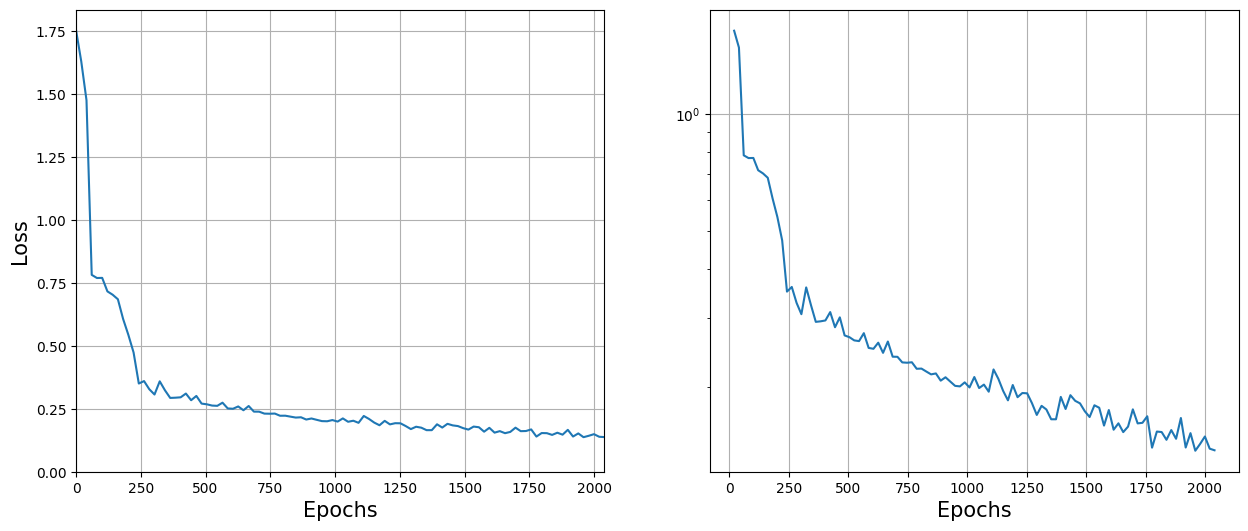

In [42]:
### Analysis  
epochs = len(loss_list)*20
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])
#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [50]:
t_Start_pred = 0; t_Final_pred = 50
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt)
node_data = odeint(model, training_data_tensor[0, 0, :, :].float(), t_eval_pred, method='rk4', options={'step_size': dt})

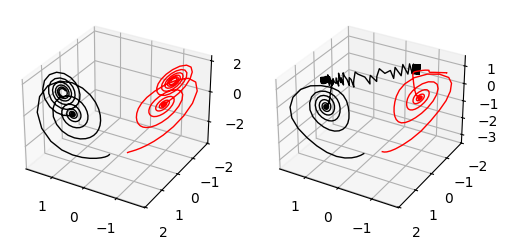

In [51]:
#Plotting results
fig = plt.figure(figsize=(6, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(xs=training_data_tensor[0, :, 0, 0], ys=training_data_tensor[0, :, 0, 1], zs=training_data_tensor[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=training_data_tensor[0, :, 1, 0], ys=training_data_tensor[0, :, 1, 1], zs=training_data_tensor[0, :, 1, 2], color = 'red', linewidth = 1 )

#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
ax1.view_init(elev = 30, azim = 120)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(xs=node_data[:, 0, 0].detach().numpy(), ys=node_data[:, 0, 1].detach().numpy(), zs=node_data[:, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
ax2.plot(xs=node_data[:, 1, 0].detach().numpy(), ys=node_data[:, 1, 1].detach().numpy(), zs=node_data[:, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

ax2.view_init(elev = 30, azim = 120)

plt.show()

In [52]:

def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[0, :index, 0, 0], ys=data_norm[0, :index, 0, 1], zs=data_norm[0, :index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[0, :index, 1, 0], ys=data_norm[0, :index, 1, 1], zs=data_norm[0, :index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

In [53]:
def plot_interact2(index):
        #Plotting results
        fig = plt.figure(figsize=(6, 8))

        #First Plot
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1.plot(xs=training_data_tensor[0, :index, 0, 0], ys=training_data_tensor[0, :index, 0, 1], zs=training_data_tensor[0, :index, 0, 2], color = 'black', linewidth = 1 )
        ax1.plot(xs=training_data_tensor[0, :index, 1, 0], ys=training_data_tensor[0, :index, 1, 1], zs=training_data_tensor[0, :index, 1, 2], color = 'red', linewidth = 1 )

        #ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
        ax1.view_init(elev = 30, azim = 120)


        #Second Plot 
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        ax2.plot(xs=node_data[:index, 0, 0].detach().numpy(), ys=node_data[:index, 0, 1].detach().numpy(), zs=node_data[:index, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
        ax2.plot(xs=node_data[:index, 1, 0].detach().numpy(), ys=node_data[:index, 1, 1].detach().numpy(), zs=node_data[:index, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

        ax2.view_init(elev = 30, azim = 120)



In [47]:
node_data.shape

torch.Size([500, 2, 3])

In [48]:
model.break_params

Parameter containing:
tensor([8.2038], requires_grad=True)

In [54]:

interact(plot_interact2, index=IntSlider(min=0, max=500, step=1))

interactive(children=(IntSlider(value=0, description='index', max=500), Output()), _dom_classes=('widget-inter…

<function __main__.plot_interact2(index)>

## Bifurcation Diagram

In [ ]:
a = 1

In [ ]:
np.vectorize(lorenz.f)

In [ ]:
integ.solve_ivp(fun = np.vectorize(lorenz.f), t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', 
                t_eval = np.arange(t_Start, t_Final, dt), )




In [ ]:
r_eval = np.arange(0, 28, 0.1)
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]

t_Start = 0; t_Final = 250; t_Transient = 230; dt = 0.01

In [ ]:
x_list = []
r_list = []
for r in tqdm(r_eval):
    lorenz.rho = lambda t: r
    
    for y0 in initial_conditions:
        output = integ.solve_ivp(fun = lorenz.f, t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', t_eval = np.arange(t_Start, t_Final, dt))
        z_plane = r-1
        z = output.y[2, int(t_Transient/dt):]

        #Where does do we cross the plane z = r-1 from below 
        
        indices = np.where((z[:-1] - z_plane)*(z[1:] - z_plane) <= 0)[0]
        for idx in indices:
            x_pts = output.y[0, int(t_Transient/dt):][idx]
            r_list.append(r)
            x_list.append(x_pts)
      



100%|██████████| 280/280 [02:05<00:00,  2.24it/s]
